In [35]:
import pandas as pd
import matplotlib.pyplot as plt

In [95]:
times_u = pd.read_csv("../data/gerlumph_data/u_dates.dat", header=None, sep=" ") 
imageA_u = pd.read_csv("../data/gerlumph_data/u_A.dat", header=None) 
imageB_u = pd.read_csv("../data/gerlumph_data/u_B.dat", header=None) 

In [106]:
times_i = pd.read_csv("../data/gerlumph_data/i_dates.dat", header=None, sep=" ") 
imageA_i = pd.read_csv("../data/gerlumph_data/i_A.dat", header=None) 

In [108]:
times_u.columns = ['t_u', 'dt_u']
imageA_u.columns = ['A_u']
imageB_u.columns = ['B_u']
times_i.columns = ['t_i', 'dt_i']
imageA_i.columns = ['A_i']

In [123]:
df = pd.concat([times_u, imageA_u, imageB_u, times_i, imageA_i], axis=1)

Text(0.75, 0.2, 'i-filter')

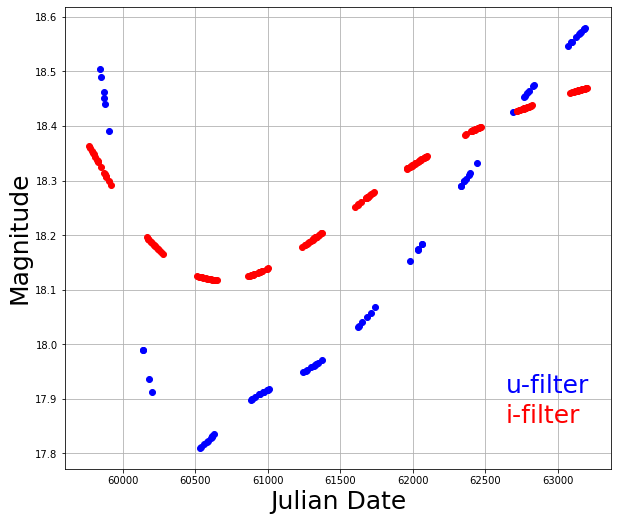

In [116]:
fig, ax = plt.subplots()
fig.set_size_inches(9.8,8.5)
plt.plot(df['t_u'], df['A_u'], "bo")
plt.plot(df['t_i'], df['A_i'], "ro")
#plt.plot(b["JulianDate"], mag_B, "darkblue")
#plt.title("Magnitudini totali delle 4 immagini", size=25)
plt.xlabel("Julian Date", size=25)
plt.ylabel("Magnitude", size=25)
plt.grid(True)
plt.figtext(0.75, 0.25, "u-filter", color='blue', size=25)
plt.figtext(0.75, 0.20, "i-filter", color='red', size=25)
#plt.figtext(0.8, 0.17, "C", color="darkslategrey", size=25)
#plt.figtext(0.8, 0.13, "D", color="black", size=25)

In [118]:
df2 = df.groupby(df['t_u']==df['t_i'])

In [120]:
df2.head()

,t_u,dt_u,A_u,B_u,t_i,dt_i,A_i
0,59843.206892,23.479157,18.50427,18.98857,59768.428229,23.031049,18.36275
1,59851.145482,23.169317,18.49004,18.98910,59774.401370,23.072382,18.35975
2,59866.146794,23.124077,18.46230,18.99011,59787.380578,23.205564,18.35327
3,59872.127243,23.808852,18.45126,18.99051,59793.384760,23.643962,18.35028
4,59878.114723,23.627871,18.44019,18.99092,59797.338191,23.541481,18.34832
